In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FixedPoint import DataFixed as Fixed
from FloatingPoint import DataFloating as Float

reportsFixed = Fixed.GetReports()
dfFixedResult, dfFixedMemory, dfFixedOptimizations = Fixed.CreateReportDataframes(reportsFixed)

reportsFloat = Float.GetReports()
dfFloatResult, dfFloatMemory, dfFloatOptimizations = Fixed.CreateReportDataframes(reportsFloat)

In [85]:
# Target device resources available
zcu104 = {
    "LUT": 230400,
    "BRAM": 312,
    "FF": 460800,
    "URAM": 96,
    "DSP": 1728,
}

In [86]:
# Add % utilization
dfFixedResult["BRAM%"] = dfFixedResult["BRAM"] / zcu104["BRAM"] * 100
dfFixedResult["DSP%"] = dfFixedResult["DSP"] / zcu104["DSP"] * 100
dfFixedResult["FF%"] = dfFixedResult["FF"] / zcu104["FF"] * 100
dfFixedResult["LUT%"] = dfFixedResult["LUT"] / zcu104["LUT"] * 100
dfFixedResult["URAM%"] = dfFixedResult["URAM"] / zcu104["URAM"] * 100

dfFloatResult["BRAM%"] = dfFloatResult["BRAM"] / zcu104["BRAM"] * 100
dfFloatResult["DSP%"] = dfFloatResult["DSP"] / zcu104["DSP"] * 100
dfFloatResult["FF%"] = dfFloatResult["FF"] / zcu104["FF"] * 100
dfFloatResult["LUT%"] = dfFloatResult["LUT"] / zcu104["LUT"] * 100
dfFloatResult["URAM%"] = dfFloatResult["URAM"] / zcu104["URAM"] * 100

In [87]:
import numpy as np

def minmax(array: np.ndarray):
    assert len(array.shape) == 1

    if np.issubdtype(array.dtype, np.integer):
        minValue = np.iinfo(array.dtype).max # Starts at the max value of type
        maxValue = np.iinfo(array.dtype).min # Starts at the min value of type
    
    if np.issubdtype(array.dtype, np.floating):
        minValue = np.finfo(array.dtype).max # Starts at the max value of type
        maxValue = np.finfo(array.dtype).min # Starts at the min value of type

    for i in range(array.shape[0]):
        if (array[i] < minValue):
            minValue = array[i]
        if (array[i] > maxValue):
            maxValue = array[i]

    return minValue, maxValue


def zNormalize(array: np.ndarray):
    assert len(array.shape) == 1

    # Precompute mean and standard deviation (std) for array.
    mean = np.mean(array)
    std = np.std(array)

    # Perform normlization
    for i in range(array.shape[0]):
        array[i] = (array[i] - mean) / std

    return array

def minMaxNormalize(array: np.ndarray):
    assert len(array.shape) == 1

    minValue, maxValue = minmax(array)

    diff = maxValue - minValue

    for i in range(array.shape[0]):
        if diff == 0:
            array[i] = 0
        else:
            array[i] = (array[i] - minValue) / diff

    return array

In [88]:
fixed_latency_ns_norm = minMaxNormalize(dfFixedResult["Latency_ns"].to_numpy(dtype=np.float32, copy=True))
fixed_ff_norm = minMaxNormalize(dfFixedResult["FF"].to_numpy(dtype=np.float32, copy=True))
fixed_lut_norm = minMaxNormalize(dfFixedResult["LUT"].to_numpy(dtype=np.float32, copy=True))
fixed_dsp_norm = minMaxNormalize(dfFixedResult["DSP"].to_numpy(dtype=np.float32, copy=True))

float_latency_ns_norm = minMaxNormalize(dfFloatResult["Latency_ns"].to_numpy(dtype=np.float32, copy=True))
float_ff_norm = minMaxNormalize(dfFloatResult["FF"].to_numpy(dtype=np.float32, copy=True))
float_lut_norm = minMaxNormalize(dfFloatResult["LUT"].to_numpy(dtype=np.float32, copy=True))
float_dsp_norm = minMaxNormalize(dfFloatResult["DSP"].to_numpy(dtype=np.float32, copy=True))

In [89]:
resource_lut_weight = 1/3
resource_ff_weight = 1/3
resource_dsp_weight = 1/3

In [90]:
latency_weight = 0.5
resource_weight = 1 - latency_weight

resource_lut_weight_float = zcu104["LUT"] / (zcu104["LUT"] + zcu104["FF"])
resource_ff_weight_float = 1 - resource_lut_weight_float



optimizations_fixed: np.ndarray = np.zeros(shape=fixed_latency_ns_norm.shape)
cost_fixed: np.ndarray = np.zeros(shape=fixed_latency_ns_norm.shape)
for i in range(len(cost_fixed)):
    cost_fixed[i] = fixed_latency_ns_norm[i] * latency_weight + resource_weight * (resource_ff_weight * fixed_ff_norm[i] + resource_lut_weight * fixed_lut_norm[i] + resource_dsp_weight * fixed_dsp_norm[i]) 
    optimizations_fixed[i] = i

optimizations_float: np.ndarray = np.zeros(shape=float_latency_ns_norm.shape)
cost_float: np.ndarray = np.zeros(shape=float_latency_ns_norm.shape)
for i in range(len(cost_float)):
    cost_float[i] = float_latency_ns_norm[i] * latency_weight + resource_weight * (resource_ff_weight * float_ff_norm[i] + resource_lut_weight * float_lut_norm[i] + resource_dsp_weight * float_dsp_norm[i]) 
    optimizations_float[i] = i

In [91]:
cost_diff: np.ndarray = np.zeros(shape=cost_fixed.shape)
for i in range(len(cost_fixed)):
    cost_diff[i] = cost_fixed[i] - cost_float[i]

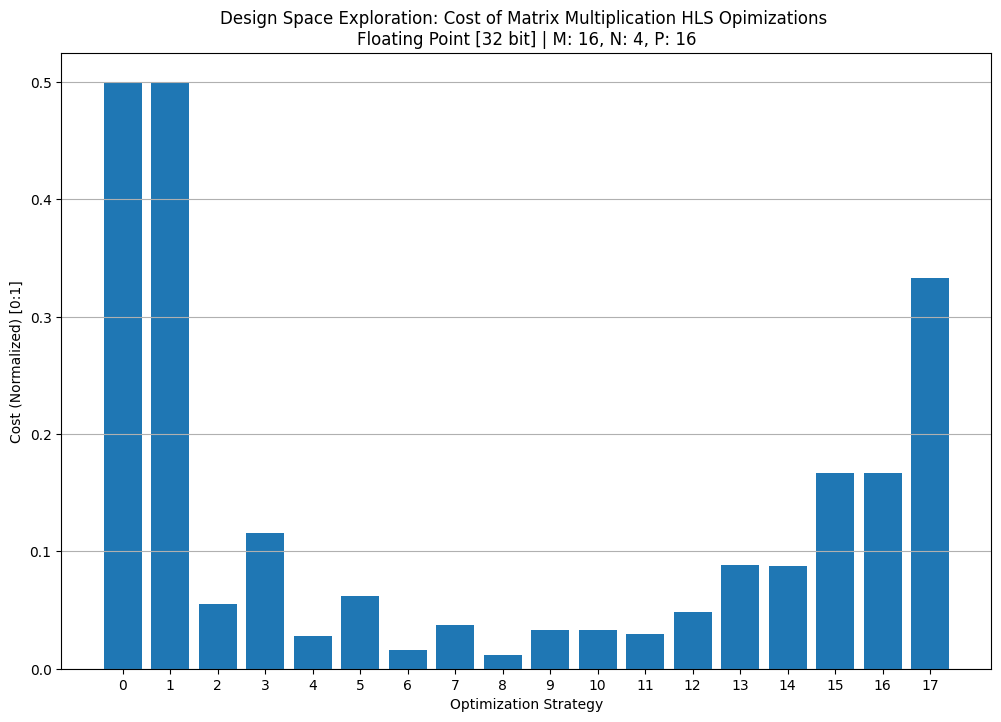

In [92]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

ax.bar(optimizations_float, cost_float)
ax.set_xticks(optimizations_float)
ax.set_xlabel("Optimization Strategy")
ax.set_ylabel("Cost (Normalized) [0:1]")
ax.set_title("Design Space Exploration: Cost of Matrix Multiplication HLS Opimizations \nFloating Point [32 bit] | M: 16, N: 4, P: 16")

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True, axis="y")

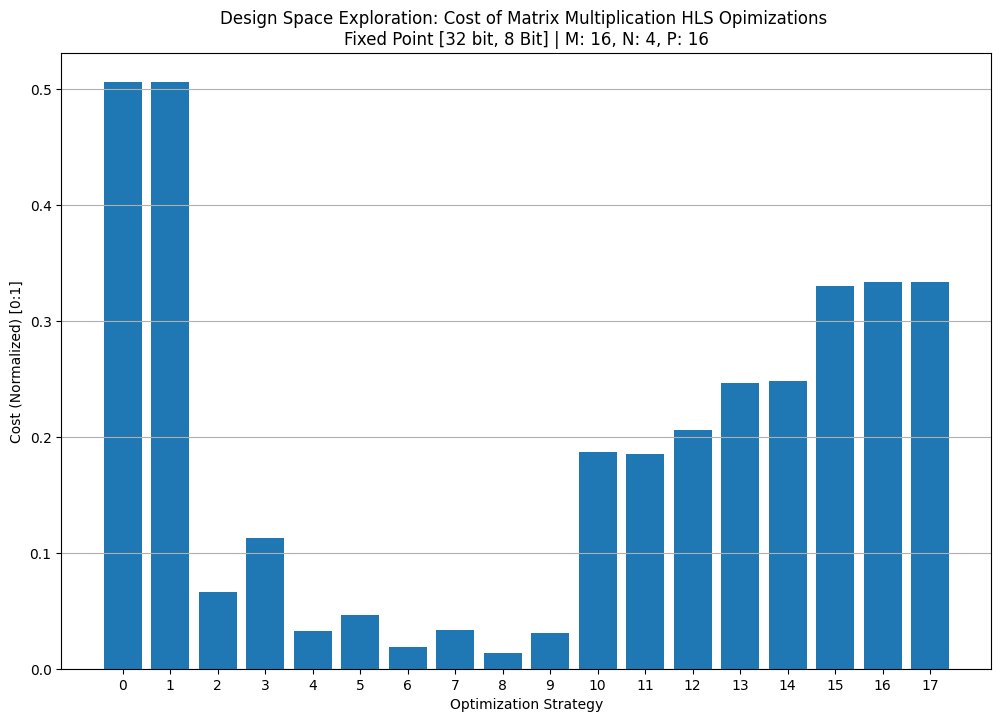

In [93]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

ax.bar(optimizations_fixed, cost_fixed)
ax.set_xticks(optimizations_fixed)
ax.set_xlabel("Optimization Strategy")
ax.set_ylabel("Cost (Normalized) [0:1]")
ax.set_title("Design Space Exploration: Cost of Matrix Multiplication HLS Opimizations \nFixed Point [32 bit, 8 Bit] | M: 16, N: 4, P: 16")

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True, axis="y")

In [94]:
cost_fixed[7]

np.float64(0.03311021625995636)

In [95]:
cost_float[7]

np.float64(0.0374050997197628)

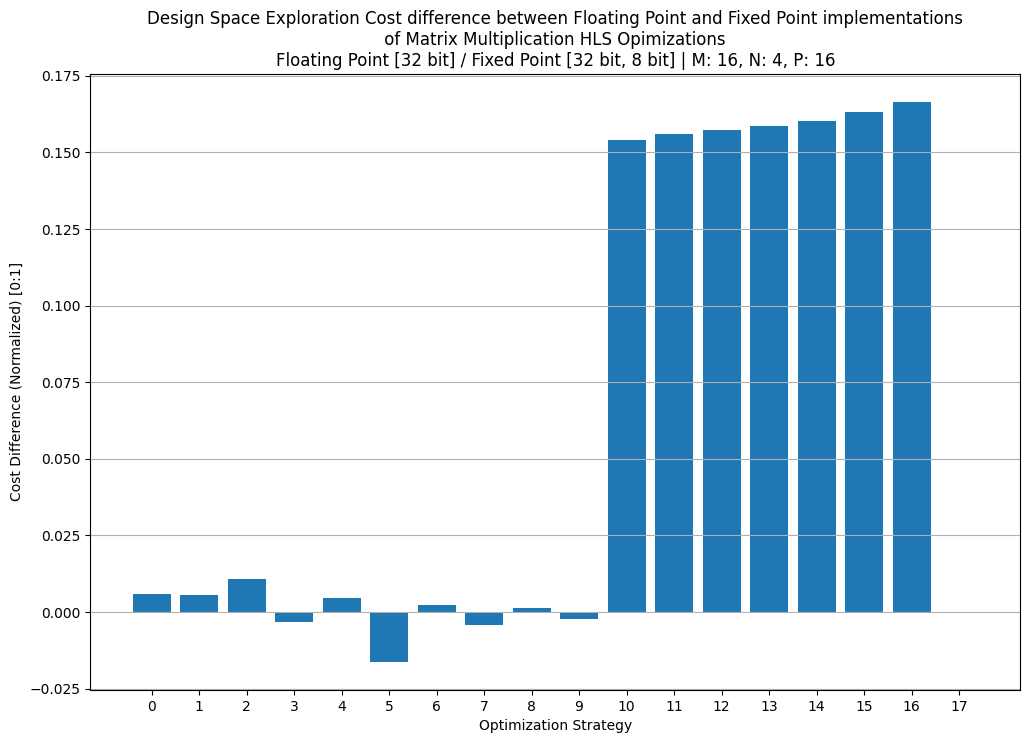

In [96]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

ax.bar(optimizations_fixed, cost_diff)
ax.set_xticks(optimizations_fixed)
ax.set_xlabel("Optimization Strategy")
ax.set_ylabel("Cost Difference (Normalized) [0:1]")
ax.set_title("Design Space Exploration Cost difference between Floating Point and Fixed Point implementations\n of Matrix Multiplication HLS Opimizations \nFloating Point [32 bit] / Fixed Point [32 bit, 8 bit] | M: 16, N: 4, P: 16")

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True, axis="y")

In [97]:
dfFixedResult

,M,P,N,Latency_ns,BRAM,DSP,FF,LUT,URAM,BRAM%,DSP%,FF%,LUT%,URAM%
Optimization 0,16,16,4,41300,0,4,199,395,0,0,0,0,0,0
Optimization 1,16,16,4,41300,0,4,192,417,0,0,0,0,0,0
Optimization 2,16,16,4,5150,0,8,113,485,0,0,0,0,0,0
Optimization 3,16,16,4,8340,0,8,402,395,0,0,0,0,0,0
Optimization 4,16,16,4,2590,0,16,33,366,0,0,1,0,0,0
Optimization 5,16,16,4,3060,0,32,259,466,0,0,2,0,0,0
Optimization 6,16,16,4,1310,0,32,31,518,0,0,2,0,0,0
Optimization 7,16,16,4,1780,0,64,258,832,0,0,4,0,0,0
Optimization 8,16,16,4,670,0,64,29,882,0,0,4,0,0,0
Optimization 9,16,16,4,1140,0,128,257,1564,0,0,7,0,1,0


In [98]:
org_latency_ns = 26010000
org_bram = 0
org_dsp = 4
org_ff = 207
org_lut = 404
org_uram = 0

In [99]:
opt_latency_ns = 388000
opt_bram = 0
opt_dsp = 129
opt_ff = 1285
opt_lut = 1985
opt_uram = 0

In [100]:
diff_latency = opt_latency_ns - org_latency_ns
diff_bram = opt_bram - org_bram
diff_dsp = opt_dsp - org_dsp
diff_ff = opt_ff - org_ff
diff_lut = opt_lut - org_lut
diff_uram = opt_uram - org_uram

In [101]:
pct_diff = diff_latency / opt_latency_ns * 100
pct_diff

-6603.6082474226805

In [114]:
pct_latency = (opt_latency_ns - org_latency_ns) / org_latency_ns * 100
pct_bram = 0
pct_dsp = (opt_dsp - org_dsp) / org_dsp * 100
pct_ff = (opt_ff - org_ff) / org_ff * 100
pct_lut = (opt_lut - org_lut) / org_lut * 100
pct_uram = 0

In [111]:
org_latency_ns / opt_latency_ns

67.0360824742268

In [112]:
org_dsp / opt_dsp

0.031007751937984496

In [113]:
(opt_latency_ns - org_latency_ns) / org_latency_ns * 100

-98.50826605151865

In [ ]:
pd.options.display.float_format = '{:20.4f}'.format
dfRes = pd.DataFrame({
    "Latency_ns": [org_latency_ns, opt_latency_ns, pct_latency],
    "BRAM": [org_bram, opt_bram, pct_bram],
    "DSP": [org_dsp, opt_dsp, pct_dsp],
    "FF": [org_ff, opt_ff, pct_ff],
    "LUT": [org_lut, opt_lut, pct_lut],
    "URAM": [org_uram, opt_uram, pct_uram]
}, index=["Unoptimized", "Optimized", "Percentage Change"])

dfRes

,Latency_ns,BRAM,DSP,FF,LUT,URAM
Unoptimized,26010000.0000,0,4.0000,207.0000,404.0000,0
Optimized,388000.0000,0,129.0000,1285.0000,1985.0000,0
Percentage Change,-98.5083,0,3125.0000,520.7729,391.3366,0


In [122]:



dfResComp = pd.DataFrame({
    "BRAM": [org_bram, opt_bram],
    "DSP": [org_dsp / zcu104["DSP"] * 100, opt_dsp / zcu104["DSP"] * 100],
    "FF": [org_ff / zcu104["FF"] * 100, opt_ff / zcu104["FF"] * 100],
    "LUT": [org_lut / zcu104["LUT"] * 100, opt_lut / zcu104["LUT"] * 100],
    "URAM": [org_uram, opt_uram]
}, index=["Unoptimized [%]", "Optimized [%]"])

dfResComp

,BRAM,DSP,FF,LUT,URAM
Unoptimized [%],0,0.2315,0.0449,0.1753,0
Optimized [%],0,7.4653,0.2789,0.8615,0
